## News Coverage about Google's San Jose Campus

A project to explore how coverage of the new San Jose Google campus was impacted by the release of a report in July 2019 estimating the impact on rents in Silicon Valley.

- Was the release of the report associated with increased discussion of rent increases and displacement?

- What kinds of topics/language appeared in articles during the month the report was published, and how does that compare to previous coverage?

Example news article:
https://sanjosespotlight.com/new-report-google-campus-will-lead-to-235m-more-in-rent-spikes/

Data Source: Articles between July 2018 and July 2019 that mentioned the San Jose Google campus were downloaded from LexisNexis as a text file, parsed, and converted to csv format

### Setup and Data Import

In [116]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import gensim
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text 

from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

%matplotlib inline

In [72]:
#Import csv of articles July 2018 - July 2019 that mention the San Jose Google campus 
housing = pd.read_csv("housing_articles.csv", encoding = "ISO-8859-1")

print("Number of articles:",len(housing))

Number of articles: 375


### Data Cleaning

In [73]:
#Combine the two full text columns, map to string to address missing values
housing["Full Text"] = housing["Full Text 1"].map(str) + housing["Full Text 2"].map(str)

#Drop unneeded Section_page, Full Text 1, Full Text 2 columns
housing = housing.drop(["Section_Page", "Full Text 1", "Full Text 2"], axis=1)

#Convert date column from string to datetime object
housing.Date_formatted = pd.to_datetime(housing.Date_formatted)

#Extract month and year from the datetime column and map to new columns
housing["Month"] = housing["Date_formatted"].map(lambda x: x.month)
housing["Year"] = housing["Date_formatted"].map(lambda x: x.year)

In [74]:
housing.head(4)

,ArticleNumber,Author,Date_formatted,Headline,Word Count,Source,Full Text,Month,Year
0,1,NaN,2019-07-15,"Developers Are Helping To Build Our Cities, No...",1094,Governing,"Developers Are Helping To Build Our Cities, No...",7,2019
1,2,Nrei Staff,2019-07-12,10 Must Reads For The Cre Industry Today (july...,1016,National Real Estate Investor,10 Must Reads For The Cre Industry Today (july...,7,2019
2,3,NaN,2019-07-11,Google's Plans For A Mega-campus In San Jose L...,1674,Cnbc,Google's Plans For A Mega-campus In San Jose L...,7,2019
3,4,NaN,2019-07-11,Rambus Strikes Deal To Move Hq To San Jose,397,East Bay Times,Rambus Strikes Deal To Move Hq To San Jose\n\n...,7,2019


### Regex to identify articles mentioning displacement or rent increases 

In [75]:
#Define displacement regex
displacement_regex = r'displac\S*|driv\S* up rents?|rent hikes?|rent increases?|rent escalation|rent growth|(?:rents?\W+(?:\w+\W+){0,2}?(?:rise|soar\S*))'

#Create df with only articles mentioning displacement
displacement = housing[housing["Full Text"].str.contains(displacement_regex)]

print("Number of articles mentioning displacement:",len(displacement))

Number of articles mentioning displacement: 71


### Language in context to check regex performance

In [76]:
#View the language that matched the regex in context
disp_regex_extract = r'(\W+(?:\w+\W+){1,2}(?:displac\S*|driv\S* up rents?|rent hikes?|rent increases?|rent escalation|rent growth|(?:rents?\W+(?:\w+\W+){0,2}?(?:rise|soar\S*)))\W+(?:\w+\W+){1,2})'
displacement["Full Text"].str.extract(disp_regex_extract)

,0
8,"affordability and displacement, in one"
22,"homelessness and displacement, he said.\n\n"
23,Jose will drive up rents even further.\n\n
24,"and housing displacement.\n\n""With respect"
25,these dramatic rent hikes.\n\nWhat adds
...,...
339,values. This displacement is becoming
344,", now worries rent increases will push"
352,", now worries rent increases will push"
356,and potentially displacing residents needs


In [77]:
#Find language around "rent" to get ideas for other relevant words/phrases not captured by current regex pattern
rent_regex_extract = r'(\W+(?:\w+\W+){1,2}(?:rents?)\W+(?:\w+\W+){1,2})'
no_displacement = housing[-housing["Full Text"].str.contains(displacement_regex)]
no_displacement["Full Text"].str.extract(rent_regex_extract).dropna()

,0
11,and keep rents low - similar
56,"project, but rents start at $"
61,paid low rent and cycled
72,"pool, residential rents also haven'"
143,deal to rent the entire
147,make the rent and afford
153,campus be rent-restrictive and
154,"faster than rents, Pringle said."
165,tenants who rent tiny rooms
166,premium on rents is still


### Chart Volume over Time

In [78]:
def format_dateindex(datedf):
    '''Takes df with Month, Year MultiIndex (created via groupby), flattens index, rearranges in "M/YYYY" format,
    and returns df'''
    
    #flatten index
    datedf.index = datedf.index.to_flat_index()
    #join with "/", flip order of month/year elements and trim first two digits of year
    datedf.index = datedf.index.map(lambda x: "/".join([str(x[1]),str(x[0])[2:]]))
    
    return datedf

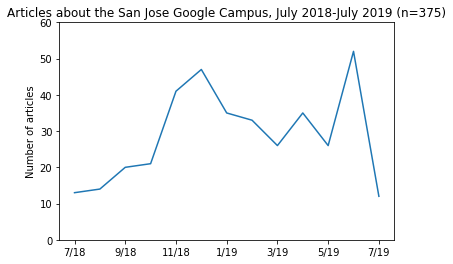

In [79]:
#Group overall volume by month and year
dates = housing.groupby(["Year","Month"]).size()
#Format index to display correctly for x-axis
dates = format_dateindex(dates)

dates.plot()
axes = plt.gca()
axes.set_ylim([0,60])
plt.ylabel("Number of articles")
plt.title("Articles about the San Jose Google Campus, July 2018-July 2019 (n=" + str(len(housing)) + ")");

### Chart Mention of Displacement/Rent Increases Over Time

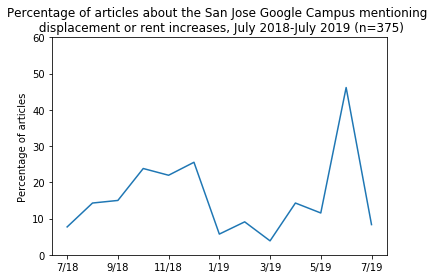

In [80]:
#Group displacement articles by month and year
disp_dates = displacement.groupby(["Year","Month"]).size()
#Format index to display correctly for x-axis
disp_dates = format_dateindex(disp_dates)

#Calculate percentage of articles mentioning displacement for each month
percent_dates = disp_dates/dates*100

percent_dates.plot()
axes = plt.gca()
axes.set_ylim([0,60])
plt.ylabel("Percentage of articles")
plt.rcParams["axes.titlesize"] = 12
plt.title("Percentage of articles about the San Jose Google Campus mentioning \n displacement or rent increases, July 2018-July 2019 (n=" + str(len(housing)) + ")");

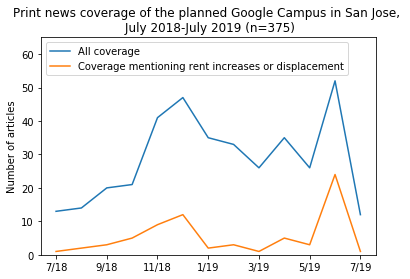

In [81]:
#Double line graph
axes = plt.gca()
axes.set_ylim([0,65])
plt.ylabel("Number of articles")
plt.title("Print news coverage of the planned Google Campus in San Jose, \n July 2018-July 2019 (n=375)")
dates.plot(label="All coverage")
disp_dates.plot(label="Coverage mentioning rent increases or displacement")
plt.legend(loc='upper left');

### Converting Full Text column to lists of strings (for use in Topic Modeling)

In [83]:
fulltext_list = housing["Full Text"].tolist()
len(fulltext_list)

375

In [85]:
housing_June = housing[(housing["Year"] == 2019) & (housing["Month"] == 6)]
textlist_June = housing_June["Full Text"].tolist()
len(textlist_June)

52

### Concatenate relevant phrases

In [108]:
#Look for multi-word phrases that appear often enough to be concatenated
phrase = "Sam_Liccardo"
#Check count of phrases in corpus
matches = [phrase
           for article in fulltext_list_test
           if phrase in article]

print(len(matches))

132


In [134]:
def concat_phrase(phrases, text_list):
    '''For each article, loop through the phrases and replace any spaces with an underscore'''
    text_list = [article.replace(phrase, phrase.replace(" ","_")) 
                 for phrase in phrases 
                 for article in text_list]
    
    return text_list

phrase_list = ["San Jose",'Sam Liccardo''New York','Mountain View']

fulltext_list = concat_phrase(phrase_list, fulltext_list)
textlist_June = concat_phrase(phrase_list, textlist_June)

## Topic Modeling##

In [135]:
def topic_model(corpus_text, min_doc=20, max_doc=0.4, num_of_topics = 10):
    '''Take a list of strings, and returns an LDA Model. 
    Uses CountVectorizor to find three letter tokens, remove stop_words.
    Default parametes remove tokens that appear in < 20 documents, or appear in more than 50% of the documents'''
    vect = CountVectorizer(min_df=min_doc, max_df=max_doc, stop_words='english', 
                           token_pattern='(?u)\\b\\w\\w\\w+\\b')

    # Fit and transform
    #The input is a list of strings 
    X = vect.fit_transform(corpus_text)

    # Convert sparse matrix to gensim corpus.
    corpus = gensim.matutils.Sparse2Corpus(X, documents_columns=False)

    # Mapping from word IDs to words (To be used in LdaModel's id2word parameter)
    id_map = dict((v, k) for k, v in vect.vocabulary_.items())
    
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=num_of_topics, id2word=id_map, passes=1, random_state=34)
    
    return (ldamodel)


def make_topicmod_wordcloud(topicmod):
    '''Takes LDA model, produces Wordcloud of Top N words in each topic'''
    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

    cloud = WordCloud(background_color='white',
                      width=2500,
                      height=1800,
                      max_words=10,
                      colormap='tab10',
                      color_func=lambda *args, **kwargs: cols[i],
                      prefer_horizontal=1.0)

    topics = topicmod.show_topics(formatted=False)

    fig, axes = plt.subplots(3, 2, figsize=(10,10), sharex=True, sharey=True)

    for i, ax in enumerate(axes.flatten()):
        fig.add_subplot(ax)
        topic_words = dict(topics[i][1])
        cloud.generate_from_frequencies(topic_words, max_font_size=300)
        plt.gca().imshow(cloud)
        plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
        plt.gca().axis('off')


    plt.subplots_adjust(wspace=0, hspace=0)
    plt.axis('off')
    plt.margins(x=0, y=0)
    plt.tight_layout()
    return plt.show()

def simple_word_cloud(text_list, font_color = "blue", maxwords = 40, custom_stopwords = ["said"]):
    '''Takes list of strings, turns into one big string, and creates a word cloud'''
    text_string = " ".join(text_list)

    stopwords = set(STOPWORDS)
    stopwords.update(custom_stopwords)

    fulltext_cloud = WordCloud(background_color='white',
                      width=3000,
                      height=2000,
                      max_words=maxwords,
                      color_func=lambda *args, **kwargs: font_color,
                      prefer_horizontal=1.0, stopwords=stopwords).generate(text_string)

    # Display the generated image
    plt.imshow(fulltext_cloud, interpolation='bilinear')
    plt.axis("off")
    
    return plt.show()

### Topic Model Results as Word Clouds

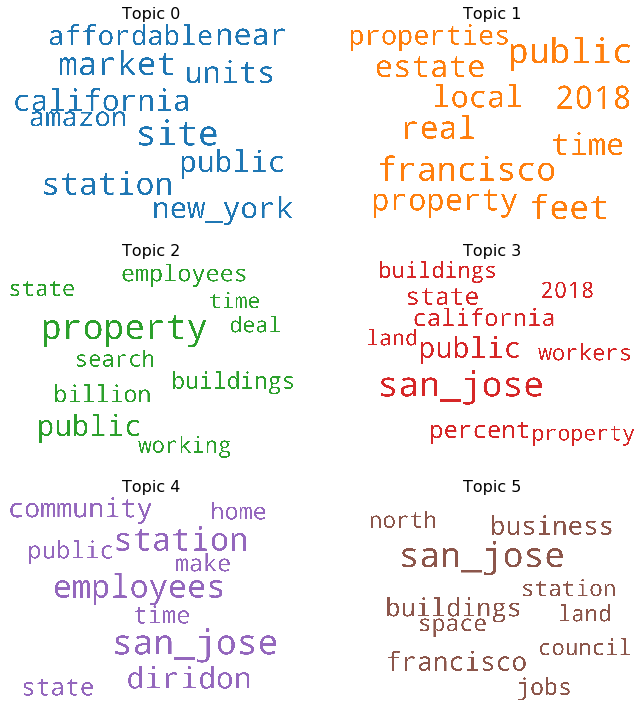

In [136]:
#All articles

topicmodel = topic_model(fulltext_list)
#topicmodel.print_topics(num_topics=10, num_words=10)

make_topicmod_wordcloud(topicmodel)

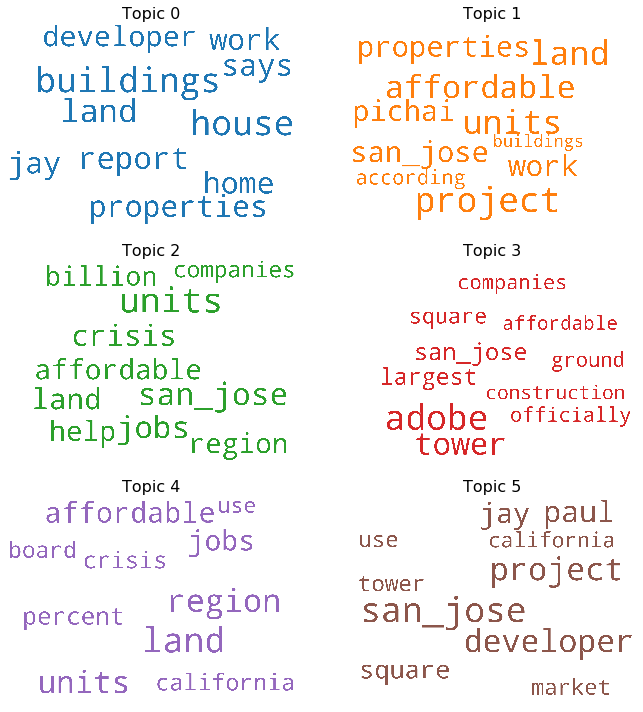

In [137]:
#June articles

topicmodel = topic_model(textlist_June, min_doc=10)
#topicmodel.print_topics(num_topics=10, num_words=10)

make_topicmod_wordcloud(topicmodel)

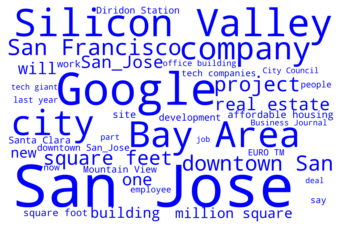

In [152]:
#Simple word cloud of all articles
simple_word_cloud(fulltext_list)

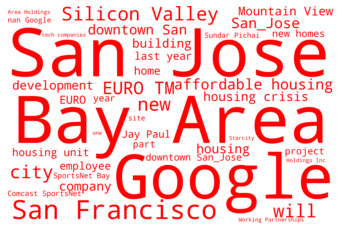

In [155]:
#Simple word cloud of June articles
simple_word_cloud(textlist_June, font_color = 'red')